# The Kopi Latte Ratio Project: Model Inference

The objective of this notebook is to use the finetuned DistilBERT model for inference on unlabelled reviews

## Load Finetuned Model and Prepare Unlabelled Data for Inference

In [1]:
import os
os.chdir('..')

In [6]:
import pandas as pd
places_unlabelled_df = pd.read_csv('data/interim/places_unlabelled.csv')
places_unlabelled_df.head()

,business_status,formatted_address,icon,icon_background_color,icon_mask_base_uri,name,photos,place_id,price_level,rating,...,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,opening_hours.open_now,plus_code.compound_code,plus_code.global_code,permanently_closed,is_cafe,is_kopitiam
0,OPERATIONAL,"136 Bedok North Ave 3, #01-152, Singapore 460136",https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,Percolate,"[{'height': 4032, 'html_attributions': ['<a hr...",ChIJV6HD-Eo92jERjhfY7NEDrOM,2.0,4.4,...,1.329291,103.936559,1.326591,103.933859,True,8WHP+84 Singapore,6PH58WHP+84,NaN,0,0
1,OPERATIONAL,"216 Bedok North Street 1, #01-32, Singapore 46...",https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,Generation Coffee Roasters (Bedok),"[{'height': 4000, 'html_attributions': ['<a hr...",ChIJhbwWY-I92jERxtB-gF22sL0,NaN,4.6,...,1.328730,103.934367,1.326030,103.931668,False,8WGM+V6 Singapore,6PH58WGM+V6,NaN,0,0
2,OPERATIONAL,"744 Bedok Reservoir Rd, #01-3029 Reservoir Vil...",https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,Refuel Cafe,"[{'height': 2268, 'html_attributions': ['<a hr...",ChIJcf_SpPk82jERM28p3SYNBnI,2.0,4.2,...,1.338910,103.922575,1.336211,103.919875,True,8WQC+2G Singapore,6PH58WQC+2G,NaN,0,0
3,OPERATIONAL,"537 Bedok North Street 3, #01-575, Singapore 4...",https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,Marie's Lapis Cafe,"[{'height': 3072, 'html_attributions': ['<a hr...",ChIJ3Vc6OY092jERhObI1bZ_4Sk,NaN,4.7,...,1.333259,103.925757,1.330559,103.923058,True,8WJF+PQ Singapore,6PH58WJF+PQ,NaN,0,0
4,OPERATIONAL,"311 New Upper Changi Rd #01-78 Bedok Mall, Sin...",https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,COFFEESARANG,"[{'height': 526, 'html_attributions': ['<a hre...",ChIJOb_8OAwj2jERPK-QVelr5Vk,NaN,4.1,...,1.326789,103.931245,1.324089,103.928545,True,8WGH+3W Singapore,6PH58WGH+3W,NaN,0,0


In [7]:
reviews_df = pd.read_csv('data/raw/reviews.csv')
reviews_df.head()

,author_name,author_url,language,original_language,profile_photo_url,rating,relative_time_description,text,time,translated,place_id
0,Rei Tan,https://www.google.com/maps/contrib/1029965202...,en,en,https://lh3.googleusercontent.com/a/ACg8ocK9Ir...,5,2 months ago,It’s great to find a cafe that serves good cof...,1716184446,False,ChIJV6HD-Eo92jERjhfY7NEDrOM
1,Supreet Kini,https://www.google.com/maps/contrib/1053282805...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjUNd...,5,2 months ago,Nice little independent cafe in Bedok. Quite a...,1715937637,False,ChIJV6HD-Eo92jERjhfY7NEDrOM
2,Emily Tan,https://www.google.com/maps/contrib/1013092694...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjWrw...,5,a month ago,Really blessed this is just around the neighbo...,1717770283,False,ChIJV6HD-Eo92jERjhfY7NEDrOM
3,Charmaine -,https://www.google.com/maps/contrib/1003983741...,en,en,https://lh3.googleusercontent.com/a/ACg8ocKJ2N...,5,2 months ago,Crowded on a PH morning and I can see why! Cof...,1716353007,False,ChIJV6HD-Eo92jERjhfY7NEDrOM
4,Wei Xin,https://www.google.com/maps/contrib/1095591166...,en,en,https://lh3.googleusercontent.com/a-/ALV-UjUBh...,5,2 months ago,This place have very delicious garlic cheese c...,1715824235,False,ChIJV6HD-Eo92jERjhfY7NEDrOM


In [8]:
reviews_infer_df = places_unlabelled_df.merge(reviews_df, on='place_id', how='inner')[['text', 'place_id','name']]

# drop NaN reviews
reviews_infer_df = reviews_infer_df.dropna(subset=['text']).reset_index(drop=True)
reviews_infer_df.head()

,text,place_id,name
0,It’s great to find a cafe that serves good cof...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate
1,Nice little independent cafe in Bedok. Quite a...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate
2,Really blessed this is just around the neighbo...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate
3,Crowded on a PH morning and I can see why! Cof...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate
4,This place have very delicious garlic cheese c...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate


## Inference on unlabelled places

In [9]:
from transformers import pipeline

classifier = pipeline("text-classification", model="kopi_latte",device=0)


In [10]:
from datasets import Dataset
from transformers.pipelines.pt_utils import KeyDataset
inference_dataset = Dataset.from_pandas(reviews_infer_df)
predictions = []
for out in classifier(KeyDataset(inference_dataset, 'text'), truncation=True):
    predictions.append(out)

In [11]:
# Concatenate predictions to the original dataframe
predictions_df = pd.concat([reviews_infer_df, pd.DataFrame(predictions)], axis=1)
predictions_df

,text,place_id,name,label,score
0,It’s great to find a cafe that serves good cof...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate,CAFE,0.974696
1,Nice little independent cafe in Bedok. Quite a...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate,KOPITIAM,0.783755
2,Really blessed this is just around the neighbo...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate,CAFE,0.969154
3,Crowded on a PH morning and I can see why! Cof...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate,CAFE,0.951836
4,This place have very delicious garlic cheese c...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate,CAFE,0.950568
...,...,...,...,...,...
17872,"Very nice desserts, very old school feel.\n\nH...",ChIJbRUNKUIU2jERHlin0Niw25M,Huat Heng Desserts,KOPITIAM,0.739473
17873,Ordered chendol for $2.50. Saw that they have ...,ChIJbRUNKUIU2jERHlin0Niw25M,Huat Heng Desserts,KOPITIAM,0.800944
17874,Located in a very obscure corner 2 shops away ...,ChIJbRUNKUIU2jERHlin0Niw25M,Huat Heng Desserts,KOPITIAM,0.911840
17875,My go to place for old school desserts. Portio...,ChIJbRUNKUIU2jERHlin0Niw25M,Huat Heng Desserts,KOPITIAM,0.975109


Each review now has a predicted label. To decide if a place is a cafe or kopitiam, we sum up the number of 

## Aggregate predictions by location and calculate scores for each label

In [20]:
# Sum up the scores by place_id & label
places_predictions_agg = predictions_df.groupby(['place_id','name', 'label'])[['score']].sum().reset_index()
places_predictions_agg.head()

,place_id,name,label,score
0,ChIJ--EXPbAb2jER94utrs6-RuI,Nam Kee Pau,KOPITIAM,4.950461
1,ChIJ-0-PEvwR2jERIahkNlKmLRA,Ba Buông Bánh Mì,KOPITIAM,4.787330
2,ChIJ-131x5YZ2jERo9zl8Ly76fw,Honolulu Cafe - The Centrepoint (HK Cha Chaan ...,KOPITIAM,4.886066
3,ChIJ-1S2tAEj2jERTu0qUzcjqVU,CORNERSHOP,CAFE,1.815885
4,ChIJ-1S2tAEj2jERTu0qUzcjqVU,CORNERSHOP,KOPITIAM,2.834643


In [21]:
# convert to wide format, calculate the ratio of CAFE scores to KOPITIAM scores
places_predictions = places_predictions_agg.pivot(index=['place_id', 'name'], columns='label', values='score').reset_index().fillna(0)
places_predictions['ratio'] = places_predictions['CAFE'] / (places_predictions['CAFE'] + places_predictions['KOPITIAM'])
places_predictions.head()

label,place_id,name,CAFE,KOPITIAM,ratio
0,ChIJ--EXPbAb2jER94utrs6-RuI,Nam Kee Pau,0.000000,4.950461,0.000000
1,ChIJ-0-PEvwR2jERIahkNlKmLRA,Ba Buông Bánh Mì,0.000000,4.787330,0.000000
2,ChIJ-131x5YZ2jERo9zl8Ly76fw,Honolulu Cafe - The Centrepoint (HK Cha Chaan ...,0.000000,4.886066,0.000000
3,ChIJ-1S2tAEj2jERTu0qUzcjqVU,CORNERSHOP,1.815885,2.834643,0.390469
4,ChIJ-1VFVgAX2jERVNhDii9zSCI,煲仔King (Claypot King) @ Serangoon,0.000000,1.980073,0.000000


<Axes: >

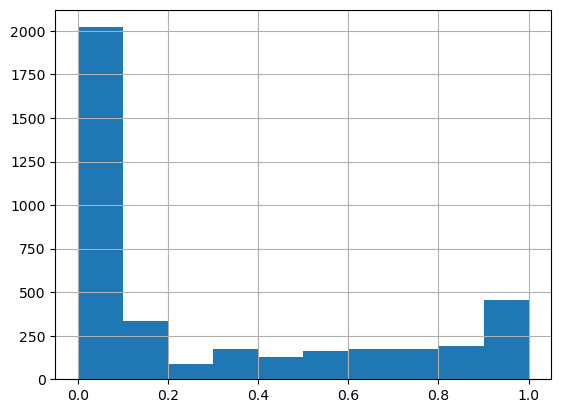

In [22]:
# plot out distribution of score ratio
places_predictions['ratio'].hist()

In [23]:
# bin the scores by 0.1 increments and check the distribution of score ratios
bins = [-1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
places_predictions['ratio_bin'] = pd.cut(places_predictions['ratio'], bins)
places_predictions['ratio_bin'].value_counts().sort_index()

ratio_bin
(-1.0, 0.0]    2021
(0.0, 0.1]        0
(0.1, 0.2]      337
(0.2, 0.3]       85
(0.3, 0.4]      172
(0.4, 0.5]      129
(0.5, 0.6]      162
(0.6, 0.7]      173
(0.7, 0.8]      172
(0.8, 0.9]      193
(0.9, 1.0]      454
Name: count, dtype: int64

Due to the limited time available to manually inspect and classify locations, I will select a threshold of ratio scores to flag out locations for manual checks. 

In [24]:
# bin the scores by quantiles and check the distribution of score ratios
places_predictions['quantile_bin'] = pd.qcut(places_predictions['ratio'], 50, duplicates='drop', labels=False)
places_predictions['quantile_bin'].value_counts().sort_index()

quantile_bin
0     2027
1       78
2       78
3       78
4       78
5       78
6       78
7       78
8       77
9       78
10      78
11      78
12      78
13      78
14      78
15      78
16      78
17      78
18      78
19     468
Name: count, dtype: int64

 A suitable number of places that I'm willing to check for is about 200. Looking at the equal-sized quantile bins, I will flag locations in the middle bins (bins 9-11) as those that need to be manually checked. This amounts to about 234 locations.

## Classify locations using prediction score ratio and flag places for manual classification

In [25]:
import numpy as np

conditions = [(places_predictions['quantile_bin'] ) > 11, (places_predictions['quantile_bin'] ) < 9]
values = ['cafe', 'kopitiam']
places_predictions['review_label'] = np.select(conditions, values, default='unsure')
places_predictions.head()

label,place_id,name,CAFE,KOPITIAM,ratio,ratio_bin,quantile_bin,review_label
0,ChIJ--EXPbAb2jER94utrs6-RuI,Nam Kee Pau,0.000000,4.950461,0.000000,"(-1.0, 0.0]",0,kopitiam
1,ChIJ-0-PEvwR2jERIahkNlKmLRA,Ba Buông Bánh Mì,0.000000,4.787330,0.000000,"(-1.0, 0.0]",0,kopitiam
2,ChIJ-131x5YZ2jERo9zl8Ly76fw,Honolulu Cafe - The Centrepoint (HK Cha Chaan ...,0.000000,4.886066,0.000000,"(-1.0, 0.0]",0,kopitiam
3,ChIJ-1S2tAEj2jERTu0qUzcjqVU,CORNERSHOP,1.815885,2.834643,0.390469,"(0.3, 0.4]",8,kopitiam
4,ChIJ-1VFVgAX2jERVNhDii9zSCI,煲仔King (Claypot King) @ Serangoon,0.000000,1.980073,0.000000,"(-1.0, 0.0]",0,kopitiam


In [26]:
# places_predictions.to_csv('data/interim/places_predictions.csv', index=False)